## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


--> sc21aur

Your full name:

--> Astle Urban Ribeiro

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import os
import torchvision
from natsort import natsorted
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [2]:
class LoadFromFolder(Dataset):         # Defining own class LoadFromFolder
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        # Return the previously computed number of images
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])

        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

In [3]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root="comp5623m-2022/train_set/train_set", transform=transforms.ToTensor())

#Splitting the train set in 80:20 - train_dataset and validation_set.
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

#Loading the Data for train_set and validation_set
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=15, shuffle=True)

In [4]:
classes  = list()
labels = open("comp5623m-2022/mapping.txt")
for map in labels:
  key, value =map.split()
  classes.append(value)
classes = tuple(classes)
no_of_classes = len(classes)
print(f"classes present:{classes}") 
print(f"Length of the classes: {no_of_classes}")

classes present:('baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella')
Length of the classes: 30


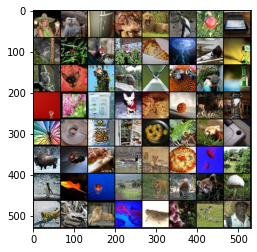

labels ['sombrero', 'baboon', 'refrigerator', 'pig', 'lion', 'penguin', 'mushroom']


In [5]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(7)]}")

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [6]:
# define a Model class
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [7]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(2704,128),     # with 32x32 input, the feature map size reduces to 5x5 with 16 channels.
    nn.ReLU(),
    nn.Linear(128,30)
)

for param in net.parameters():
    print(param.shape)

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([128, 2704])
torch.Size([128])
torch.Size([30, 128])
torch.Size([30])


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [8]:
# TO COMPLETE
from torch import nn, optim 

nepochs = 10
model_name = 'cnn_single_batching.pt'
results_path = 'comp5623m-2022/'+model_name
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} validation loss: {ltst: .3f}")

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.401 validation loss:  3.400
epoch: 1 training loss:  3.397 validation loss:  3.394
epoch: 2 training loss:  3.389 validation loss:  3.380
epoch: 3 training loss:  3.357 validation loss:  3.317
epoch: 4 training loss:  3.250 validation loss:  3.176
epoch: 5 training loss:  3.135 validation loss:  3.106
epoch: 6 training loss:  3.057 validation loss:  3.009
epoch: 7 training loss:  2.999 validation loss:  2.986
epoch: 8 training loss:  2.965 validation loss:  2.970
epoch: 9 training loss:  2.932 validation loss:  2.924


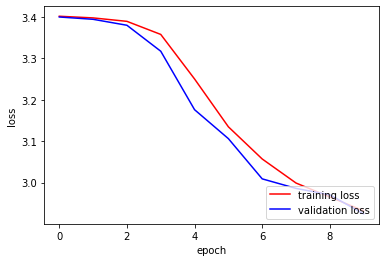

In [9]:
model_name = 'cnn_single_batching.pt'
results_path = 'comp5623m-2022/'+model_name
data = torch.load(results_path)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'b', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
fig.savefig("single_batch_loss.svg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [10]:
# TO COMPLETE
# TO COMPLETE
nepochs = 200
n_epochs_stop = 10
no_epochs_improve = 0
early_stop=False
model_name = 'cnn_complete_training.pt'
results_path = 'comp5623m-2022/'+model_name
statsrec1 = np.zeros((4,nepochs))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
min_val_loss=np.Inf

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
        
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, net)
    
    ### early stop if there is not change in validation loss over 10 instances of the epochs.
    if ltst<min_val_loss:
      no_epochs_improve = 0
      min_val_loss = ltst
    else:
       no_epochs_improve+=1
    if epoch > 5 and no_epochs_improve == n_epochs_stop:
            print('Stopping as Loss is not improving' )
            early_stop = True
            break
    statsrec1[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f}   validation loss: {ltst: .3f}")

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec1}, results_path)

epoch: 0 training loss:  2.894   validation loss:  2.918
epoch: 1 training loss:  2.875   validation loss:  2.907
epoch: 2 training loss:  2.846   validation loss:  2.868
epoch: 3 training loss:  2.811   validation loss:  2.833
epoch: 4 training loss:  2.777   validation loss:  2.803
epoch: 5 training loss:  2.725   validation loss:  2.754
epoch: 6 training loss:  2.673   validation loss:  2.759
epoch: 7 training loss:  2.631   validation loss:  2.678
epoch: 8 training loss:  2.586   validation loss:  2.689
epoch: 9 training loss:  2.556   validation loss:  2.636
epoch: 10 training loss:  2.523   validation loss:  2.653
epoch: 11 training loss:  2.472   validation loss:  2.615
epoch: 12 training loss:  2.437   validation loss:  2.603
epoch: 13 training loss:  2.394   validation loss:  2.561
epoch: 14 training loss:  2.353   validation loss:  2.545
epoch: 15 training loss:  2.307   validation loss:  2.526
epoch: 16 training loss:  2.280   validation loss:  2.576
epoch: 17 training loss:

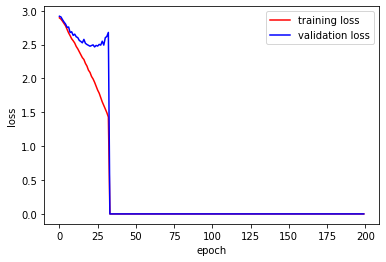

In [11]:
model_name = 'cnn_complete_training.pt'
results_path = 'comp5623m-2022/'+model_name
data = torch.load(results_path)
statsrec1 = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec1[0], 'r', label = 'training loss', )
plt.plot(statsrec1[2], 'b', label = 'validation loss' )
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
fig.savefig("complete_training_loss.svg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [16]:
# TO COMPLETE
#Data Augmentation

data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.3)
])

dataset = ImageFolder(root="comp5623m-2022/train_set/train_set",transform=data_aug)

#Splitting the train set in 80:20 - train_dataset and validation_set.
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

#Loading the Data for train_set and validation_set
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=15, shuffle=True)

In [17]:
# Adding drop out
model_ft2 = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.Dropout(p=0.5),        #Adding dropout with default value of 0.5
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(2704,128),     # with 32x32 input, the feature map size reduces to 5x5 with 16 channels.
    nn.ReLU(),
    nn.Linear(128,30)
)

for param in model_ft2.parameters():
    print(param.shape)

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([128, 2704])
torch.Size([128])
torch.Size([30, 128])
torch.Size([30])


In [18]:
def stats1(loader, model_ft2):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model_ft2(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [19]:
nepochs = 200
n_epochs_stop = 10
no_epochs_improve = 0
early_stop=False
model_name = 'cnn_with_fine_tuning.pt'
results_path = 'comp5623m-2022/'+model_name

statsrec2 = np.zeros((4,nepochs))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft2.parameters(),  lr=0.001, momentum=0.9)
min_val_loss=np.Inf
for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model_ft2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(validation_loader, model_ft2)
    ### early stop if there is not change in validation loss over 10 instances of the epochs.
    if ltst<min_val_loss:
      no_epochs_improve = 0 
      min_val_loss = ltst
    else:
       no_epochs_improve+=1
    if epoch > 5 and no_epochs_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
    statsrec2[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f}  validation loss: {ltst: .3f} ")

# save network parameters, losses and accuracy
torch.save({"state_dict": model_ft2.state_dict(), "stats": statsrec2}, results_path)

epoch: 0 training loss:  3.402  validation loss:  3.400 
epoch: 1 training loss:  3.398  validation loss:  3.394 
epoch: 2 training loss:  3.391  validation loss:  3.385 
epoch: 3 training loss:  3.371  validation loss:  3.354 
epoch: 4 training loss:  3.325  validation loss:  3.295 
epoch: 5 training loss:  3.259  validation loss:  3.226 
epoch: 6 training loss:  3.206  validation loss:  3.201 
epoch: 7 training loss:  3.180  validation loss:  3.175 
epoch: 8 training loss:  3.157  validation loss:  3.153 
epoch: 9 training loss:  3.122  validation loss:  3.136 
epoch: 10 training loss:  3.101  validation loss:  3.078 
epoch: 11 training loss:  3.080  validation loss:  3.080 
epoch: 12 training loss:  3.064  validation loss:  3.063 
epoch: 13 training loss:  3.027  validation loss:  3.012 
epoch: 14 training loss:  3.000  validation loss:  3.035 
epoch: 15 training loss:  2.943  validation loss:  2.967 
epoch: 16 training loss:  2.913  validation loss:  2.929 
epoch: 17 training loss:

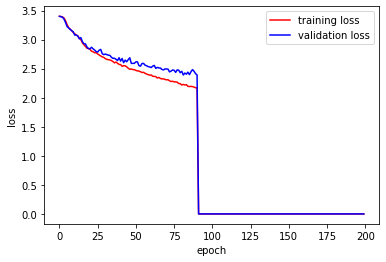

In [20]:
model_name = 'cnn_with_fine_tuning.pt'
results_path = 'comp5623m-2022/'+model_name
data = torch.load(results_path)
statsrec2 = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec2[0], 'r', label = 'training loss', )
plt.plot(statsrec2[2], 'b', label = 'validation loss' )
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
fig.savefig("fine_tuning.svg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

Text(0.5, 1.0, 'Training Loss Comparison')

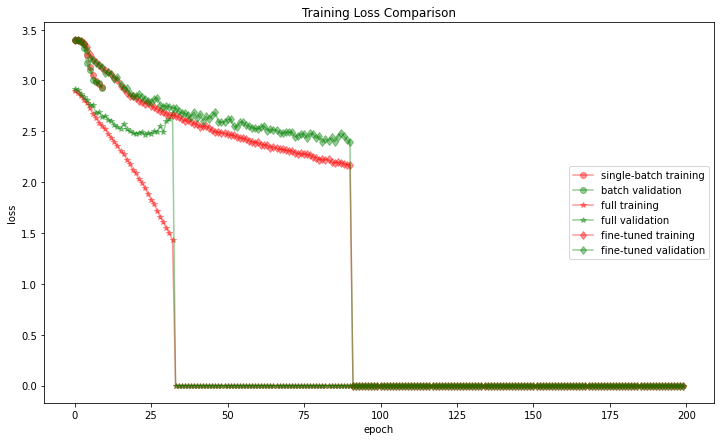

In [21]:
plt.figure(figsize=(12,7))

plt.plot(statsrec[0], 'r', label = 'single-batch training', marker='o', alpha=0.4)
plt.plot(statsrec[2], 'g', label = 'batch validation', marker='o', alpha=0.4)


plt.plot(statsrec1[0], 'r', label = 'full training', marker='*', alpha=0.4)
plt.plot(statsrec1[2], 'g', label = 'full validation' , marker='*', alpha=0.4)


plt.plot(statsrec2[0], 'r', label = 'fine-tuned training', marker='d', alpha=0.4)
plt.plot(statsrec2[2], 'g', label = 'fine-tuned validation', marker='d', alpha=0.4)


plt.legend(loc='center right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss Comparison')

Explain what can be seen in the graphs.

1) Single Batch Training
A single-fully-connected layer model is trained with learning rate = 0.001 for 10 Epochs. As shown in Graph, our model is performing well on single batch of training data and validation set. Only single batch training set is not enough to make our model to predict well in a validation set.
2) Complete Training Set
Overfitting is a phenomenon where a model fits too well on training data so that when new unseen examples are to be classified, model is not able to classify accurately as it learned to recognize specific image but not the patterns in those images.
As we are training this CNN Architecture only on single batch of training set, our model is facing difficulty to recognize unseen images in the validation set. 
As shown in Graph, training loss is gradually decreasing, while validation loss after some epochs started to increase resulting in lower validation accuracy.
In our case overfitting can be solved by fine tuning the complete training set.
3) Fine Tuned Model
I modified the network by using methods like data augmentation and adding drop out to the model and let it train for 200 epochs. The loss can be seen on Graph. After 200 epochs, the lowest loss on validation set was 2.391 on 81th Epoch. To make our model learn accurate patterns we need to train on more epochs which is around 1000 Epochs for better accuracy.


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [22]:
# TO COMPLETE
import pandas as pd
categories_names=(pd.read_csv('comp5623m-2022/mapping.txt', header=None,sep="\t")).drop(columns=[2])
categories_names=categories_names[1]
categories_names[:5]

0       baboon
1       banana
2          bee
3        bison
4    butterfly
Name: 1, dtype: object

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_confusion_matrix(model, loader, categories_name):
  all_preds = torch.tensor([])
  all_labels = torch.tensor([])

  i=0
  with torch.no_grad():
    for batch in loader:
      images, labels = batch
      
      preds = model(images)

      all_preds = torch.cat((all_preds, preds),dim=0)
      all_labels = torch.cat((all_labels, labels),dim=0)

    fig, ax = plt.subplots(figsize=(25, 25))
    cm = confusion_matrix(all_labels.tolist(), all_preds.argmax(dim=1).tolist())

    conf_matrix=pd.DataFrame(data=cm, columns=categories_names, index=categories_names)
    sns.heatmap(conf_matrix, annot=True, fmt='d')

    plt.show()

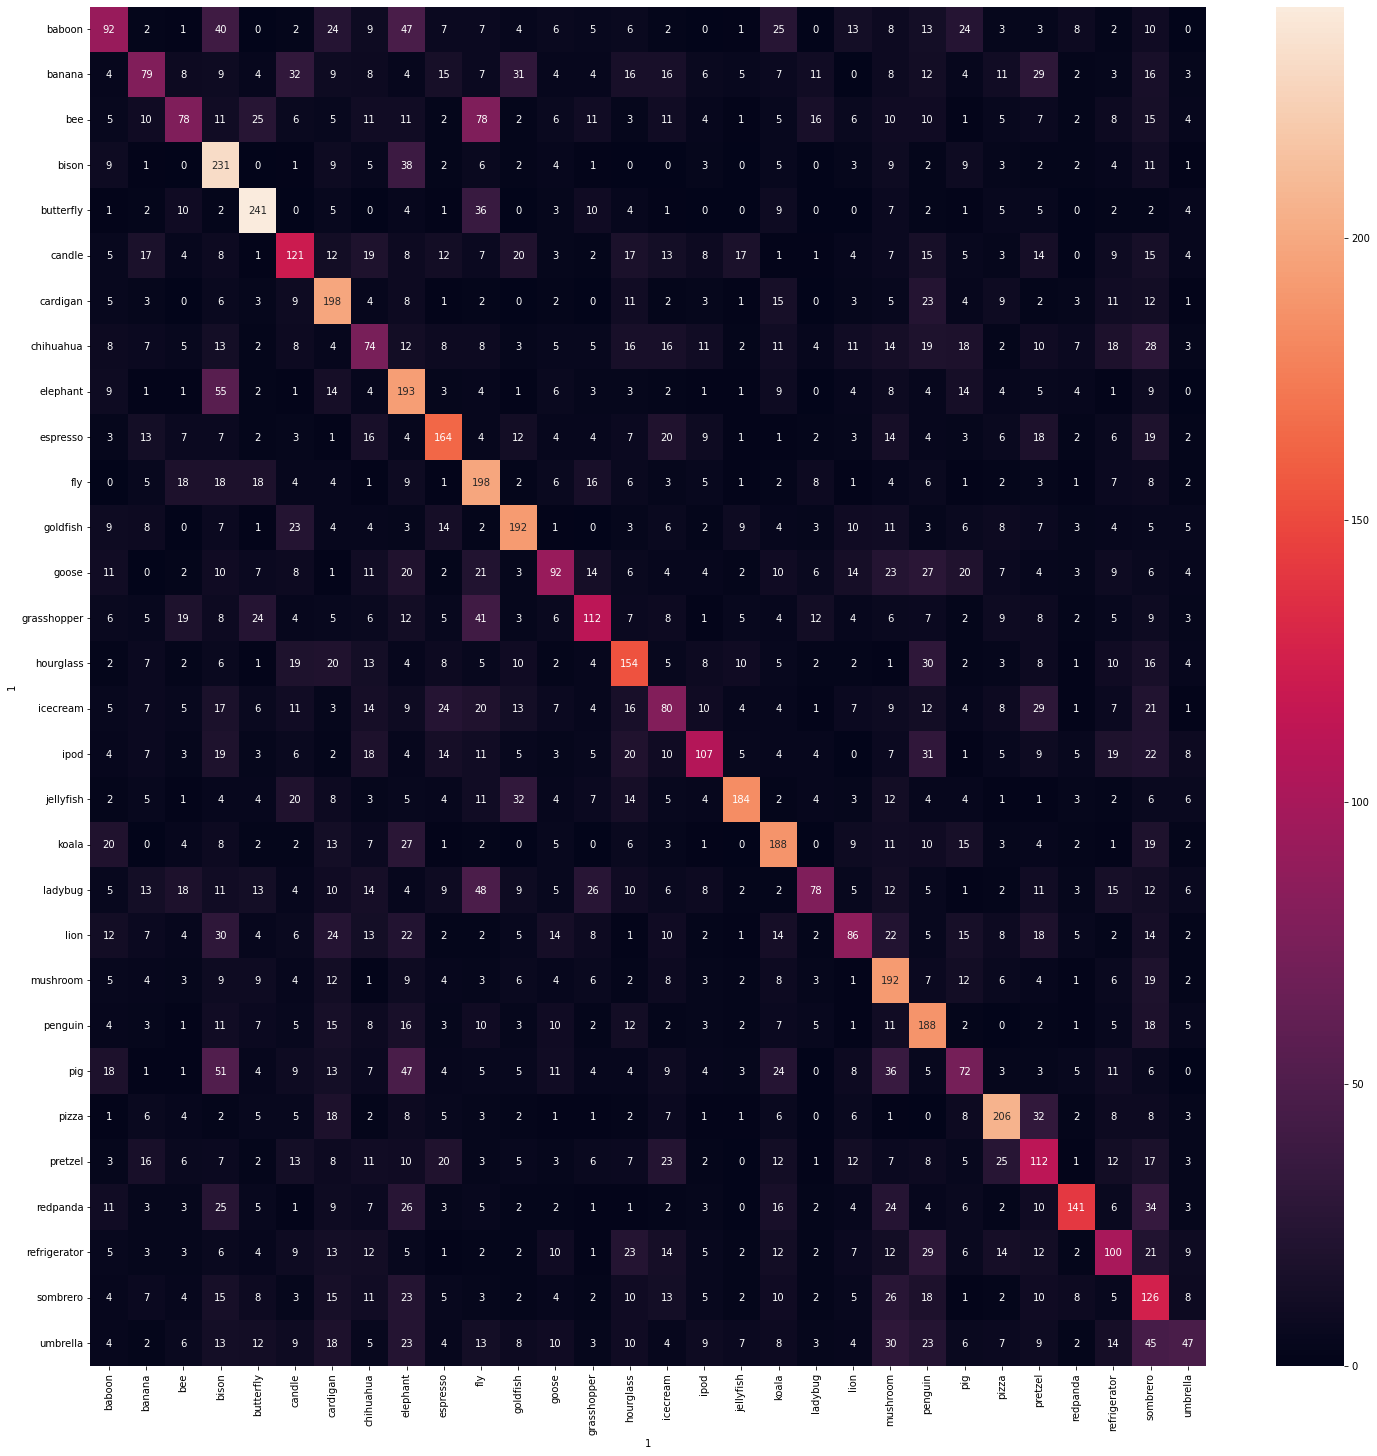

In [26]:
generate_confusion_matrix(model_ft2, train_loader, categories_names)

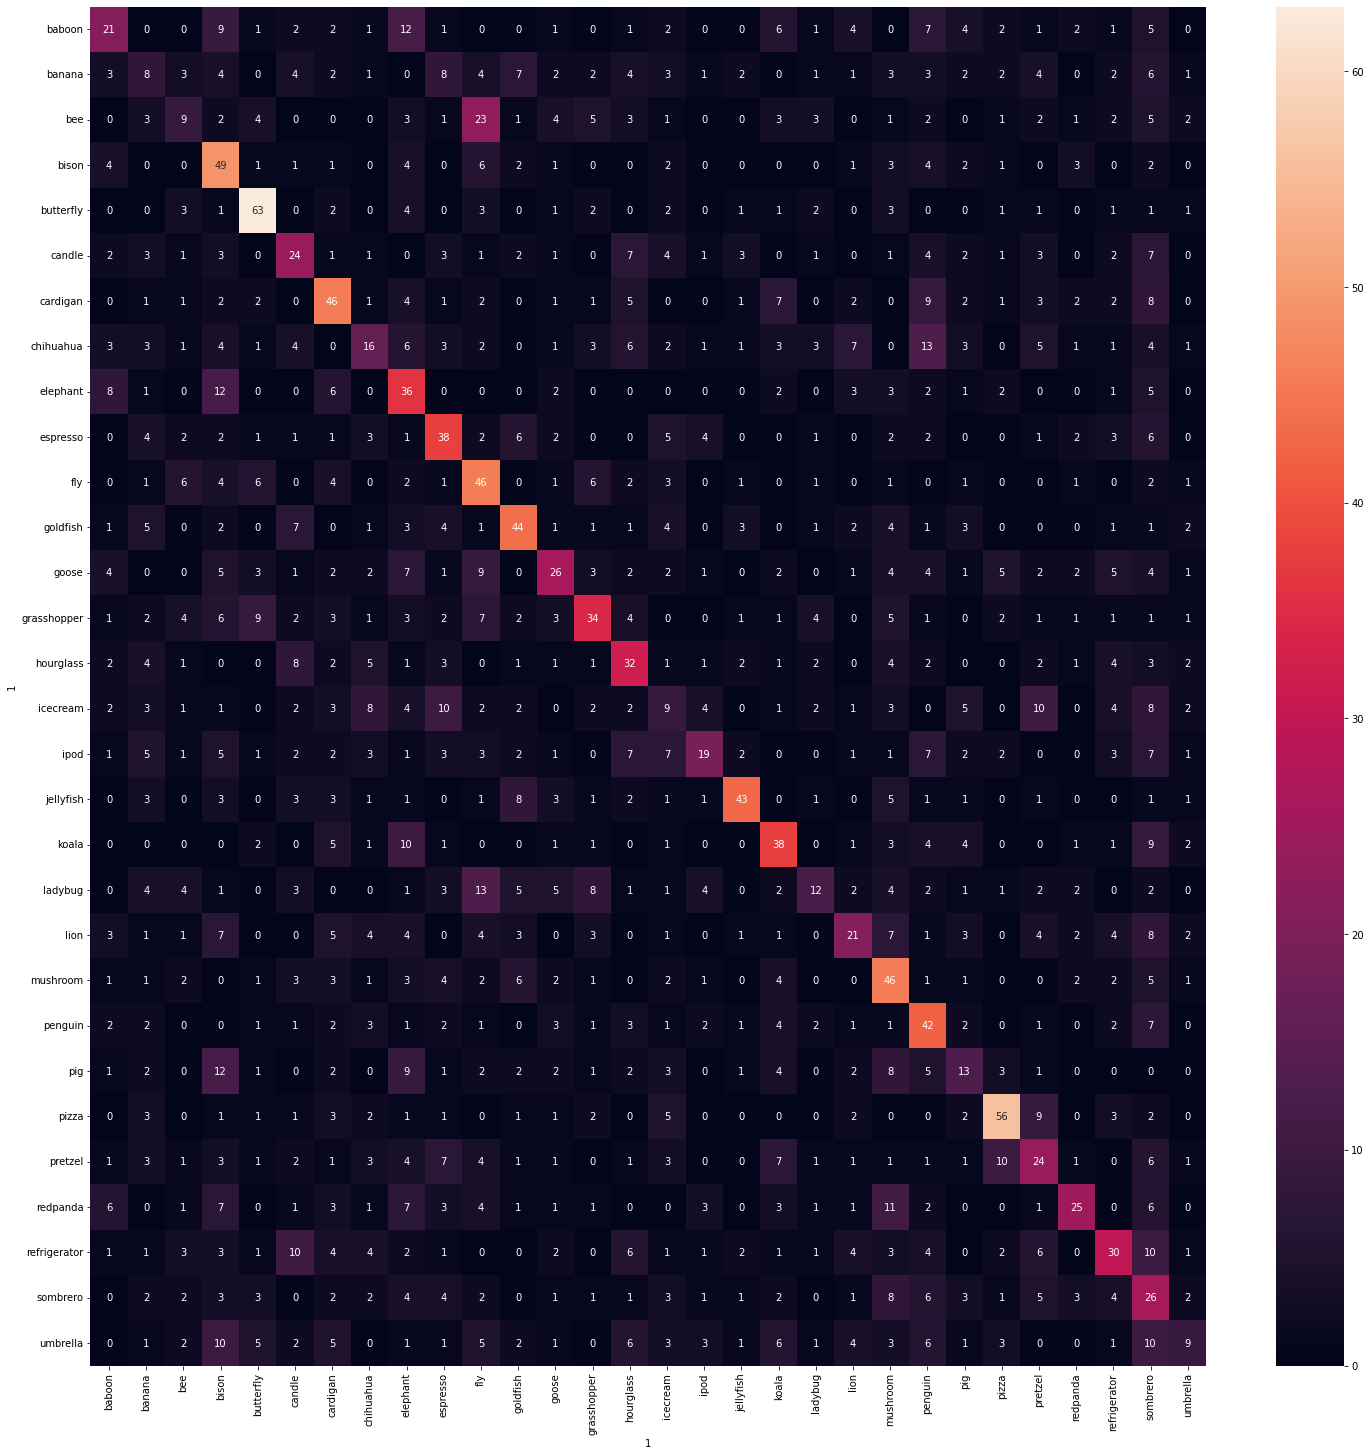

In [27]:
generate_confusion_matrix(model_ft2, validation_loader, categories_names)

What conclusions can be drawn from the confusion matrices?

I created confusion matrix for both training and validation set as shown above. On whole validation set with best model, model got loss of 2.391 and training set (with augmented data) got 2.192 loss.



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [28]:
class TestDataset(Dataset):
    def __init__(self, input_dir, transform=None):
        self.transform = transform
        
        self.img_list = []
        for filename in os.listdir(input_dir):
            self.img_list.append((os.path.join(input_dir, filename)))
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        
        img = Image.open(img_name).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, img_name

In [29]:

 transform = transforms.ToTensor()
test_dataset = TestDataset(
    input_dir="comp5623m-2022/test_set/test_set",
    transform=transform
)

predictions = []

for img, img_name in test_dataset:
    output = model_ft2(img.unsqueeze(0))
    predictions.append({
         "ID": os.path.basename(img_name),
         "Category": int(torch.argmax(output))
    })  


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [31]:
df = pd.DataFrame(predictions)
df

,ID,Category
0,c5693b7d_ab8f.JPEG,18
1,9e70a764_2962.JPEG,6
2,b54e8c45_5503.JPEG,18
3,fe6b0876_df17.JPEG,27
4,e57c80f8_247c.JPEG,21
...,...,...
1495,b63a5d25_d8cb.JPEG,7
1496,3af31804_7970.JPEG,3
1497,4e3f5caf_7840.JPEG,4
1498,76e43404_ba33.JPEG,1


In [32]:
df.to_csv("sc21aur.csv", index=False)



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [50]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /Users/omkarzende/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/omkarzende/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [51]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [52]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [53]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [54]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    # TO COMPLETE
    x=torch.tensor(model.features[layer_idx].weight,requires_grad=False)
    return x
    # return filters

In [55]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

/var/folders/v0/d3krfyfx77s59fyqx5px34yh0000gn/T/ipykernel_21995/1871289704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(model.features[layer_idx].weight,requires_grad=False)


For your testing purposes, the following code blocks test the dimensions of the function output.

In [56]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [57]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



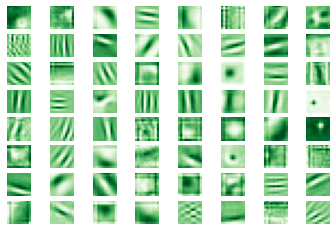

In [58]:
# limit how many filters to show
disp_img = 64

# compute the dimensions of the plot
plt_dim = int(math.sqrt(disp_img))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:disp_img]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="Greens")  # cmap Reds Greens Blues gray
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [59]:
# TO COMPLETE
# reading the picture 
im=Image.open('man_bike.JPEG').convert("RGB")

Run the code cell below to apply the image transformation expected by the model.

In [60]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [61]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """

    # TO COMPLETE
    model_weights=[]
    conv_layers=[]
    all_layers=[]
    counter = 0 
    maxpool=[]
    model_children = list(model.children())
    # append all the conv layers and their respective weights to the list

    for j in range(len(model_children[0])):
        child= model_children[0][j]
        all_layers.append(child)
        if type(child) == nn.MaxPool2d:
            
            counter += 1
            #model_weights.append(child.weight)
            conv_layers.append(child)


    
    results = [all_layers[0](image)]
  
    for i in range(1, len(all_layers)):
        # pass the result from the last layer to calculate next function
        x=all_layers[i](results[-1])
        results.append(x)       # each function's result will be save in the list of result
        if len(results[i][0][0]) == len(results[i-1][0][0])// 2:
          maxpool.append(x)
       
    # make a copy of the `results` to tensor
    maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]
    
    return maxpool
    # return feature_maps

In [62]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

/var/folders/v0/d3krfyfx77s59fyqx5px34yh0000gn/T/ipykernel_21995/2879768119.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]


For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [63]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

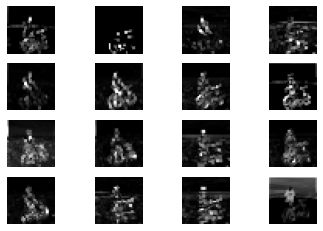

In [64]:
# TO COMPLETE
# limit how many filters to show
disp_img = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(disp_img))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[0][0].numpy()[:disp_img]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()

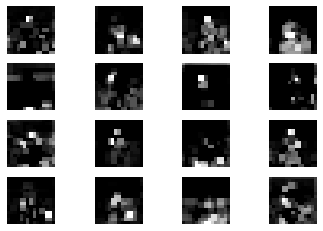

In [65]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[1][0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()

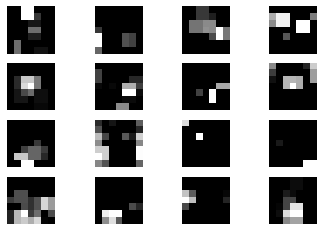

In [66]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(feature_maps[2][0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


Indice 0:   Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
A convolution operation is performed on the 2D matrix provided in the system. An image is modified and made into two where the product of these two must help in reporting the value in the output.

Indice 4:   ReLU(inplace=True)  #It's a activaion function which provides the ability to handle non-linear features.

Indice 6:   Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

The kernel size for filters gradually decreases. (11,11) -> (5,5) -> (3,3)
As we go deeper into the network, the filters are quite difficult to interpret what’s it’s trying to do but a general estimation can be done based on observations.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

As we move deeper and deeper into the filter, the size of both the filter and the feature map shrinks. By visualising, we can see what the filter is actually focusing on.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [68]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [69]:
model = alexnet(pretrained=True)

In [70]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [71]:
output.shape

torch.Size([1, 1000])

In [72]:
max(output.detach().numpy().tolist()[0])

15.24361801147461

In [74]:
output.detach().numpy().tolist()[0].index(15.24361801147461)

870

In [75]:
pred_cls.numpy()[0][0]

870

In [76]:
import pandas as pd
classes = pd.read_table('Alexnet_classes.txt', header=None)

In [77]:
 print(classes.iloc[pred_cls.numpy()[0][0]])

0    tricycle, trike, velocipede
Name: 870, dtype: object


### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [78]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[:,-1].backward()
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image).detach() 
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
     activations[:, i, :, :] *= pooled_gradients[i]


    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap

In [79]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

In [80]:
heatmap.shape

torch.Size([7, 7])

torch.Size([7, 7])

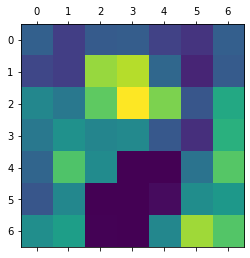

In [81]:
plt.matshow(heatmap.squeeze())
heatmap.shape

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [82]:
# TO COMPLETE
def display_heatmap(heatmap,image):
  # Resize the heatmap to match the size of the image.
  (w, h) = (image.shape[0], image.shape[1])
  heatmap = cv2.resize(heatmap.numpy(), (w, h))

  # Rescale the image to a 0-255 integer range
  numerator = heatmap - np.min(heatmap)
  denominator = (heatmap.max() - heatmap.min()) + 1e-8
  heatmap_normalized = numerator / denominator  
  heatmap_normalized = (heatmap_normalized * 255).astype("uint8")
    
  # Apply a colormap to the heatmap using cv2.applyColorMap(heatmap, cv2.COLORMAP_JET).
  heatmap_normalized = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    
  # Multiply all values of heatmap by 0.4 to reduce colour saturation.
  heatmap_normalized=heatmap_normalized * 0.4
    
  # Superimpose the heatmap onto the original image
  weighted_image= cv2.addWeighted(heatmap_normalized, 0.7, image, 0.3, 0)
    
  # Normalize the image between 0-255 again.
  numerator = weighted_image - np.min(weighted_image)
  denominator = (weighted_image.max() - weighted_image.min()) + 1e-8
  final_image = numerator / denominator
  final_image = (final_image * 255).astype("uint8")

  return final_image

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [83]:
# TO COMPLETE

# Display the resulting image.
image = cv2.imread('man_bike.JPEG')
image=cv2.resize(image,(256,256))
image = np.asarray(image, np.float64)

In [84]:
display=display_heatmap(heatmap,image)

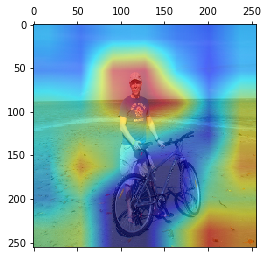

In [85]:
plt.matshow(display[:, :, ::-1])

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [ ]:
# TO COMPLETE

In [86]:
animal=Image.open('img2.jpg')

# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

animal = data_transform(animal)

In [89]:
model243 = alexnet(pretrained=True)

# pass our test image through our new model with the hook
output = model243(animal.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

pred_cls

tensor([[157]])

In [90]:
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100  
print(classes.iloc[pred_cls.numpy()[0][0]])

0    papillon
Name: 157, dtype: object


In [91]:
# generate heatmap
heatmap = generate_heatmap(output, pred_cls, model243, animal.unsqueeze(0))

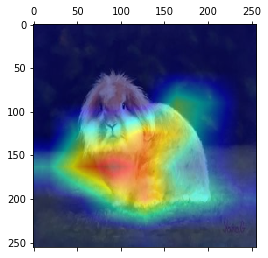

In [92]:
rabbit=cv2.imread('img2.jpg')
rabbit=cv2.resize(rabbit,(256,256))
rabbit = np.asarray(rabbit, np.float64)
result = display_heatmap(heatmap, rabbit)
plt.matshow(result[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

The model classified the image as a collie, however the image is of a rabbit. Therefore it is an incorrect classification.

According to the Grad-CAM heatmap, AlexNet's model seeks to uncover attributes that match the papillon's obvious qualities, although some other species, such as rabbit, have these properties as well. As a result, AlexNet model will need to be trained inorder to to find more rabbit or papillon-specific traits.

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
